# Day 17 流形学习(Manifold-Learning)
虽然 PCA 是一个灵活、快速且容易解释的算法，但是它对存在非线性关 系的数据集的处理效果并不太好
<br>流形学习 是一种无监督评估器，它试图将一个低维度流形嵌入到一个高维度空间来描述数据集
<hr>当你思考流形时，建议你设想有一张纸——一个存在于我们所熟悉的三维世界中的二维物体——它可以从两个维度弯折或卷起。提到流形学习这个术语时，可以把这张纸看成那个嵌入三维空间中二维流形。
<hr>这里将深入介绍几种流形方法的技巧，包括
* 多维标度法(multidimensional scaling，MDS)
* 局 部 线 性 嵌 入 法(locally linear embedding，LLE) 
* 保 距 映 射 法(isometric mapping， Isomap)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()


# warnings.filterwarnings(action='ignore')

下面用函数创建一组数据，构成单词“HELLO”的形状:

In [2]:
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('../figure/hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('../figure/hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

调用该函数并且画出结果数据,输出图像包含了很多二维的点，它们组成了单词“HELLO”的形状:

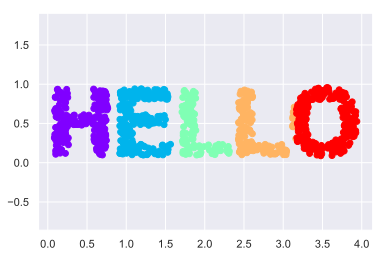

In [3]:
X = make_hello()
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

## 1.多维标度法(MDS)
通过观察这个数据集，可以看到数据集中选中的 x 值和 y 值并不是对数据的最基本描述: 即使放大、缩小或旋转数据，“HELLO”仍然会很明显。例如，如果用一个旋转矩阵来旋转数据，x 和 y 的值将会改变，但是数据形状基本还是一样的

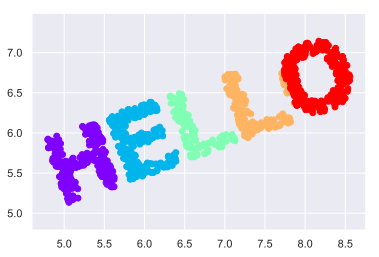

In [4]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

这说明 x 和 y 的值并不是数据间关系的必要基础特征。这个例子中**真正的基础特征是每个点与数据集中其他点的距离**。表示这种关系的常用方法是关系(距离)矩阵:对于 N 个 点，构建一个 N × N 的矩阵，元素 (i , j ) 是点 i 和点 j 之间的距离。我们用 Scikit-Learn 中 的 **pairwise_distances 函数**来计算原始数据的关系矩阵:

In [5]:
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)
D.shape

(1000, 1000)

对于 N = 1000 个点，获得了一个 1000 × 1000 的矩阵。画出该矩阵:

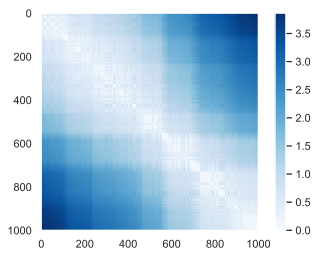

In [6]:
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

如果用类似方法为已经做过旋转和平移变换的数据构建一个距离矩阵，将看到同样的结果:

In [7]:
D2 = pairwise_distances(X2)
np.allclose(D, D2)

True

虽然距离矩阵给出了一个数据集内部关系的表现形式，这种形式与数据集的旋转和投影无关。但距离矩阵的可视化效果却显得不够直观。

虽然从(x, y)坐标计算这个距离矩阵很简单，但是**从距离矩阵转换回x坐标值和y坐标值 却非常困难**。这就是**多维标度法**可以解决的问题:<font color='blue'>它可以将一个数据集的距离矩阵还原成 一个 D 维坐标来表示数据集</font>。下面来看看多维标度法是如何还原距离矩阵的——**MDS 模型将非相似性(dissimilarity)参数设置为 precomputed 来处理距离矩阵:**

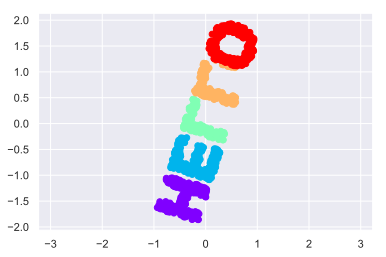

In [8]:
from sklearn.manifold import MDS

model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

由上图可看出: 仅仅依靠描述数据点间关系的 N × N 距离矩阵，MDS 算法就可以为数据还原出一种可行的二维坐标

## 2.将MDS用于流形学习

既然可以在 一个二维平面中简单地旋转数据，那么也可以用以下函数将其投影到三维空间

In [9]:
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
    
X3 = random_projection(X, 3)
X3.shape

(1000, 3)

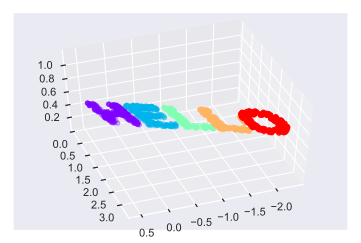

In [10]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

现在可以通过 MDS 评估器输入这个三维数据，计算距离矩阵，然后得出距离矩阵的最优二
维嵌入结果。结果还原了原始数据的形状:

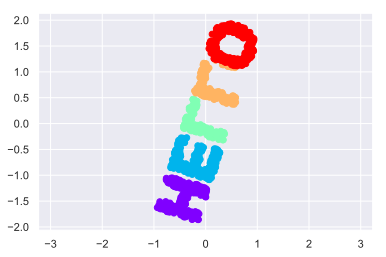

In [11]:
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

以上就是使用流形学习评估器希望达成的基本目标:**给定一个高维嵌入数据，寻找数据的 一个低维表示，并保留数据间的特定关系**。在 MDS 的示例中，保留的数据是每对数据点之间的距离。

## 3.非线性嵌入:当MDS失败时

前面介绍了线性嵌入模型，它包括将数据旋转、平移和缩放到一个高维空间的操作。但是 当嵌入为非线性时，即超越简单的操作集合时，MDS 算法就会失效。

In [12]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

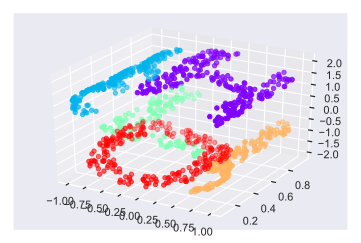

In [13]:
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

如果尝试用一个简单的 MDS 算法来处理这个数据，就无法展示数据非线性嵌入的特征，
进而导致我们丢失了这个嵌入式流形的内部基本关系特性:

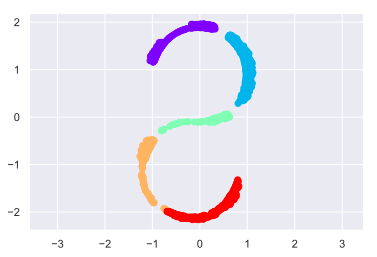

In [14]:
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

## 4.非线性流形:局部线性嵌

MDS 算法构建嵌入时，总是期望保留相距很远的数据点之间的距离。但是如果修改算法，让它只保留比较 接近的点之间的距离呢?

<img src='../figure/LLE-vs-MDS.png'>

LLE 有好几种表现形式，这里用 modified LLE 算法来还原嵌入的二维流形。

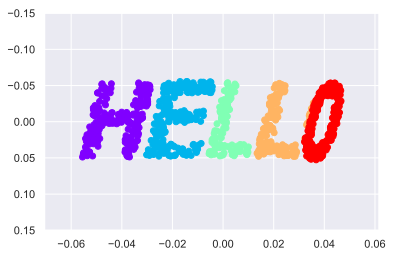

In [15]:
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

## 5.示例:用Isomap处理人脸数据

流形学习经常被用于探索高维数据点内部的关系。常见的高维数据示例就是图像数据。例 如，一组 1000 像素的图像经常被看成是 1000 维度的点集合，每幅图像中每一个像素的亮度信息定义了相应维度上的坐标值。

In [16]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

(200, 2914)

200幅图像，每一幅图像有 2914 个像素。换句话说，这些图像可以被看成是一个 2914 维空间中的数据点的集合!
<br>先将几幅图像进行快速可视化，看看要处理的数据:

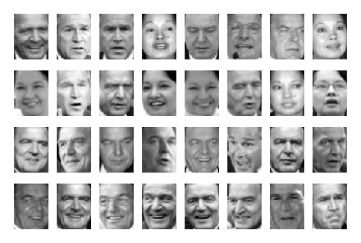

In [17]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

我们希望画出这 2914 维数据的一个低维嵌入结果，以此来了解图像的基本关系。可以从 计算 PCA 开始，从而查看解释方差的比率。通过这个比率，就可以判断需要多少线性特 征才能描述数据:

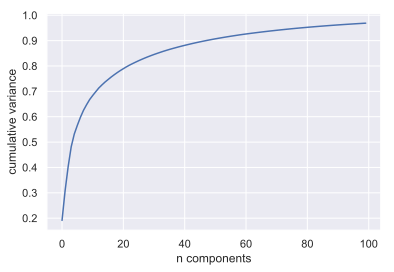

In [18]:
from sklearn.decomposition import PCA

model = PCA(100, svd_solver='randomized').fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

这个数据大约需要 100 个成分才能保存 95% 的方差，说明该数据所需的维度非常高，仅通过几个线性成分无法描述。

由于存在上述问题，因此非线性流形嵌入方法，如 LLE 和 Isomap，就可以派上用场了:

In [19]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(200, 2)

输出的是对所有图像的一个二维投影。为了更好地理解该投影表示的含义，来定义一个函数，在不同的投影位置输出图像的缩略图: (??)

In [20]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # 不展示相距很近的点
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

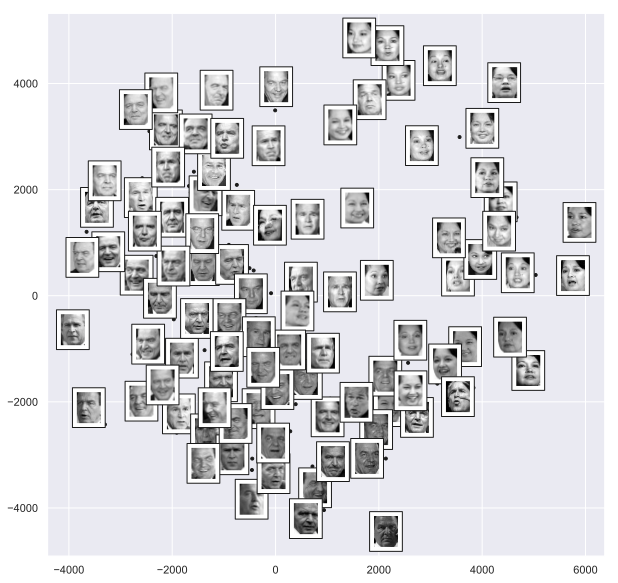

In [21]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

结果非常有趣。前两个 Isomap 维度仿佛就描述了图像的整体特征:图像明暗度从左至右 持续变化，人脸朝向从下到上持续变化。这是一组非常好的视觉指标，呈现了数据中一些基本特征。
<br>我们可以根据这个结果将数据进行分类，用流形特征作为分类算 法的输入数据。

## 6.示例:手写数字的可视化结构

使用流形学习进行可视化MNIST 手写数字数据集

In [22]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

它包含了 70000 幅图像，每幅图像有 784 像素(也就是说，图像是 28 像素 × 28 像素)。 与前面的处理方式相同，先看看前面几幅图像

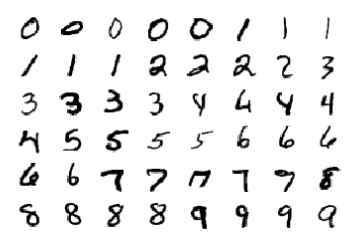

In [23]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

下面来计算这些数据的流形学习投影。
<br>考虑到计算速度的影响，我们仅使用数据集的 1/30 进行学习，大概包括 2000 个数字样本点(由于流形学习的计算扩展性比较差，因此一开始用几千个示例数据也许是不错的选择，这样可以在完整计算之前进行 相对快速的探索):

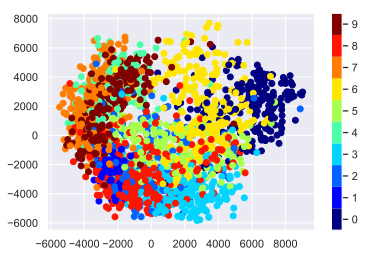

In [24]:
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

该散点图结果展示了数据点间的一些关系，但是点的分布有一点拥挤。我们可以一次只查看一个数字，来获得更清楚的结果:

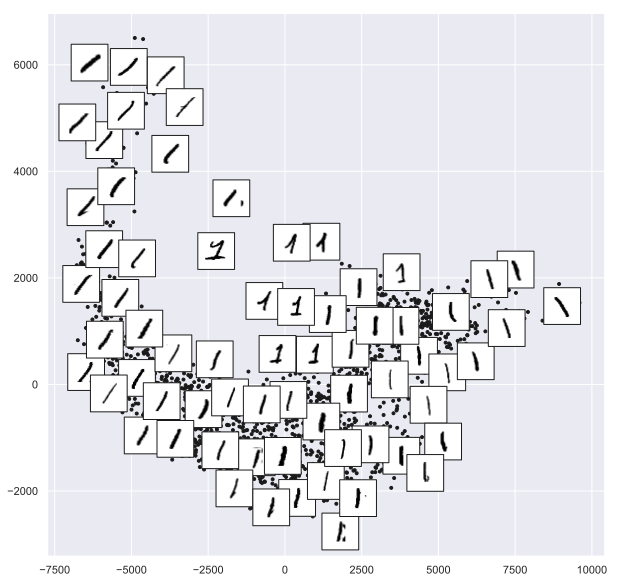

In [25]:
from sklearn.manifold import Isomap

# 选择1/4的数字"1"来投影
data = mnist.data[mnist.target == 1][::4]

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')

结果表明，数据集中数字“1”的形式是多种多样的。这个数据在投影空间中分布在一个 较宽的曲面上，都像是沿着数字的方向。当你沿着图像向上看，将发现一些带着“帽子” 且 / 或带有“底座”的数字“1”，虽然这些形式在整个数据集中非常少。可见，流形投影 可以让我们发现数据中的异常点(即邻近的数字片段被偷偷放入抽取的图像中)。

还是不太明白这种图有什么用.